In [106]:
import pandas as pd
import os
import glob
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import random
import matplotlib.pyplot as plt

In [84]:
df = pd.read_csv("../clean_dataset.csv")
df.drop(["tbp_tile_type", "tbp_lv_location_simple", "iddx_1"], axis=1, inplace=True)

In [85]:
#Quantidade total de pacientes
df["patient_id"].nunique()

1042

## Garantindo Aleatoriedade de Sample

In [86]:
paciente_cancer = df.loc[df['target'] == 1, 'patient_id'].unique()

paciente_cancer_free = df[~df['patient_id'].isin(paciente_cancer)]

paciente_cancer = df[df['patient_id'].isin(paciente_cancer)]

paciente_cancer_1 = paciente_cancer[paciente_cancer['target'] == 1]
paciente_cancer_0 = paciente_cancer[paciente_cancer['target'] == 0]

paciente_cancer_0 = (
    paciente_cancer_0
    .sample(frac=1, random_state=100)
    .groupby('patient_id')             
    .head(20)                        
)

paciente_cancer_free = (
    paciente_cancer_free
    .sample(frac=1, random_state=100)
    .groupby('patient_id')             
    .head(20)  
)

df = pd.concat([
    paciente_cancer_free, 
    paciente_cancer_1, 
    paciente_cancer_0
]).reset_index(drop=True)

In [87]:
df

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,...,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,tbp_lv_dnn_lesion_confidence
0,ISIC_9169450,0,IP_3487012,75.0,male,posterior torso,6.80,20.282044,13.484147,33.305466,...,24.132400,1.287953,4.660852,1.951048,0.229084,0,136.259613,1480.521729,132.707031,100.000000
1,ISIC_9664789,0,IP_1117889,55.0,female,posterior torso,3.34,13.589914,11.039805,20.965593,...,9.066269,0.000000,0.993099,2.636439,0.535714,45,93.081299,947.594177,135.242065,93.363273
2,ISIC_1388012,0,IP_7412246,60.0,female,anterior torso,2.85,25.836410,22.873770,29.611540,...,7.710174,0.736911,1.115177,4.070386,0.169491,15,-11.647030,1290.989000,5.192139,99.936240
3,ISIC_3400094,0,IP_7652019,30.0,female,upper extremity,3.56,28.311140,22.556800,40.726440,...,11.839230,1.626155,3.162014,2.319676,0.296820,20,225.319200,1292.768000,51.805300,100.000000
4,ISIC_1646068,0,IP_3238049,55.0,male,anterior torso,3.97,22.842575,15.736442,30.108792,...,10.242404,0.951705,5.096707,2.190793,0.190217,90,156.181091,1221.595947,20.338623,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20830,ISIC_1198690,0,IP_0273153,50.0,male,anterior torso,2.70,34.002143,15.974695,24.034132,...,7.483208,1.381028,4.836400,2.173045,0.214876,110,180.181824,1211.710083,1.691956,100.000000
20831,ISIC_5739818,0,IP_0273153,50.0,male,upper extremity,5.66,18.893194,13.152790,22.972445,...,15.226620,4.868802,4.703961,2.260487,0.365132,75,317.307373,1400.012451,71.964478,98.724049
20832,ISIC_0432879,0,IP_3987348,45.0,female,anterior torso,16.21,30.815737,21.047806,23.619421,...,53.243314,2.291641,2.910701,4.093103,0.131712,70,67.307159,1283.182861,-101.534302,95.987833
20833,ISIC_4278106,0,IP_3987348,45.0,female,anterior torso,2.60,20.822934,15.483805,29.322558,...,7.128990,0.724653,4.541077,1.806853,0.343137,90,119.841980,1222.942993,44.996338,100.000000


## Estratificação de Grupos de Forma que Pereça o balanço da Classe Alvo

In [88]:
#Quantidade de instâncias da Classe Alvo
print(len(df[df["target"]==1]))
print(len(df[df["target"]==0]))

393
20442


In [89]:
#Ignorar a unicidade da especificação da classe alvo por pessoa
df.drop(["patient_id", "isic_id"], axis=1, inplace=True)


In [90]:
df = df.reset_index(drop=True)

In [91]:
df

,target,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,...,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,tbp_lv_dnn_lesion_confidence
0,0,75.0,male,posterior torso,6.80,20.282044,13.484147,33.305466,31.581835,38.995068,...,24.132400,1.287953,4.660852,1.951048,0.229084,0,136.259613,1480.521729,132.707031,100.000000
1,0,55.0,female,posterior torso,3.34,13.589914,11.039805,20.965593,19.512713,24.984832,...,9.066269,0.000000,0.993099,2.636439,0.535714,45,93.081299,947.594177,135.242065,93.363273
2,0,60.0,female,anterior torso,2.85,25.836410,22.873770,29.611540,27.546780,39.298390,...,7.710174,0.736911,1.115177,4.070386,0.169491,15,-11.647030,1290.989000,5.192139,99.936240
3,0,30.0,female,upper extremity,3.56,28.311140,22.556800,40.726440,38.211050,49.600040,...,11.839230,1.626155,3.162014,2.319676,0.296820,20,225.319200,1292.768000,51.805300,100.000000
4,0,55.0,male,anterior torso,3.97,22.842575,15.736442,30.108792,27.756716,37.793155,...,10.242404,0.951705,5.096707,2.190793,0.190217,90,156.181091,1221.595947,20.338623,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20830,0,50.0,male,anterior torso,2.70,34.002143,15.974695,24.034132,25.879966,41.638747,...,7.483208,1.381028,4.836400,2.173045,0.214876,110,180.181824,1211.710083,1.691956,100.000000
20831,0,50.0,male,upper extremity,5.66,18.893194,13.152790,22.972445,23.671769,29.743671,...,15.226620,4.868802,4.703961,2.260487,0.365132,75,317.307373,1400.012451,71.964478,98.724049
20832,0,45.0,female,anterior torso,16.21,30.815737,21.047806,23.619421,27.652857,38.826367,...,53.243314,2.291641,2.910701,4.093103,0.131712,70,67.307159,1283.182861,-101.534302,95.987833
20833,0,45.0,female,anterior torso,2.60,20.822934,15.483805,29.322558,30.791743,35.963968,...,7.128990,0.724653,4.541077,1.806853,0.343137,90,119.841980,1222.942993,44.996338,100.000000


## Transformação de Cada Tipo de Coluna

In [92]:
colunas_categoricas = df.select_dtypes(exclude='number').columns.tolist()
colunas_numericas = df.drop("target", axis=1).select_dtypes(include='number').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), colunas_numericas),
        ('cat', OneHotEncoder(), colunas_categoricas)
    ]
)

In [110]:
#Criação de Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('tree', DecisionTreeClassifier(random_state=100))
])

param_grid = {
    'tree__criterion': ['gini', 'entropy'],
    'tree__max_depth': [None, 3, 5, 10, 50, 100],
    'tree__min_samples_split': [2, 5, 10, 20]
}

cv_stratified = StratifiedKFold(n_splits=3, shuffle=True, random_state=100)

## Treinamento Modelo Básico

In [111]:
X = df.drop("target", axis=1)
y = df["target"]

grid_search = GridSearchCV(
    estimator=pipeline,   
    param_grid=param_grid,
    cv=cv_stratified, 
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X, y)

melhor_modelo = grid_search.best_estimator_

Fitting 3 folds for each of 48 candidates, totalling 144 fits


In [112]:
preprocessor = melhor_modelo.named_steps['preprocessor']

modelo_arvore = melhor_modelo.named_steps['tree']

feature_names = preprocessor.get_feature_names_out()

df_importancia = pd.DataFrame({
    'feature': feature_names,
    'importance': modelo_arvore.feature_importances_
})

df_importancia = df_importancia.sort_values(by='importance', ascending=False)

df_importancia

,feature,importance
34,num__tbp_lv_dnn_lesion_confidence,0.133540
8,num__tbp_lv_H,0.126248
21,num__tbp_lv_minorAxisMM,0.075783
12,num__tbp_lv_areaMM2,0.055983
0,num__age_approx,0.052488
9,num__tbp_lv_Hext,0.048002
26,num__tbp_lv_radial_color_std_max,0.045699
32,num__tbp_lv_y,0.045148
6,num__tbp_lv_C,0.039048
4,num__tbp_lv_B,0.036404


In [113]:
media = grid_search.cv_results_['mean_test_score'][grid_search.best_index_]
desvio = grid_search.cv_results_['std_test_score'][grid_search.best_index_]

print(f"Score: {media:.4f} ± {desvio:.4f}")

Score: 0.6564 ± 0.0084


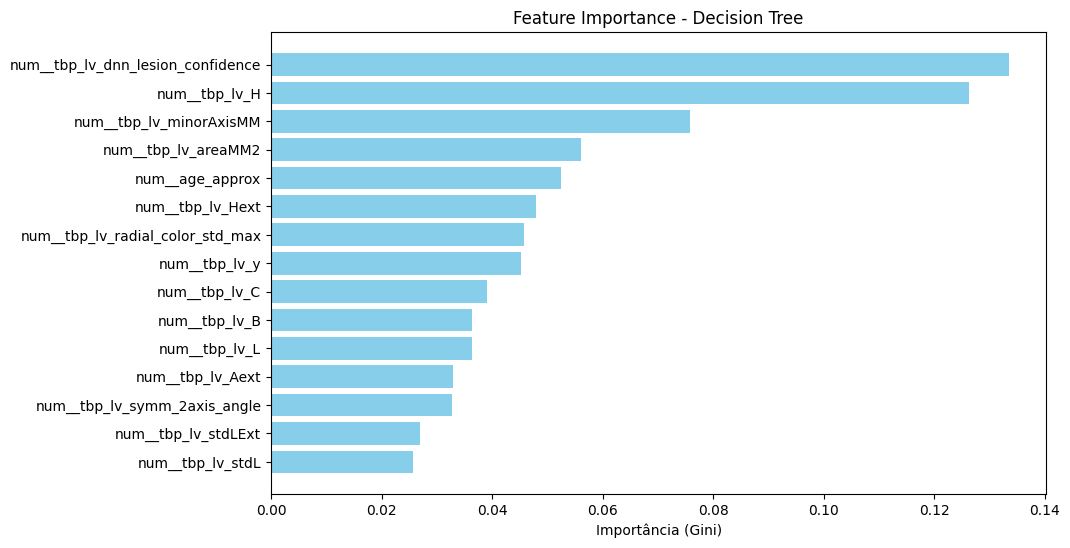

In [114]:
plt.figure(figsize=(10, 6))
plt.barh(df_importancia['feature'][:15], df_importancia['importance'][:15], color='skyblue')
plt.gca().invert_yaxis() 
plt.xlabel('Importância (Gini)')
plt.title('Feature Importance - Decision Tree')
plt.savefig("./DT_top10_features")
plt.show()

In [103]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('rf', RandomForestClassifier(random_state=100)) 
])

param_grid = {
    'rf__n_estimators': [50, 100, 200, 300],  
    'rf__max_depth': [None, 10, 20],      
    'rf__min_samples_split': [2, 5, 10, 15],  
    'rf__class_weight': ['balanced'] 
}

cv_stratified = StratifiedKFold(n_splits=3, shuffle=True, random_state=100)

X = df.drop("target", axis=1)
y = df["target"]


grid_search = GridSearchCV(
    estimator=pipeline,   
    param_grid=param_grid,
    cv=cv_stratified, 
    scoring='f1_macro',
    verbose=1,
    n_jobs=-1
)

print("Iniciando treinamento do Random Forest...")
grid_search.fit(X, y)

best_model = grid_search.best_estimator_

Iniciando treinamento do Random Forest...
Fitting 3 folds for each of 48 candidates, totalling 144 fits


Melhor F1 Macro: 0.6968
Melhores Parâmetros: {'rf__class_weight': 'balanced', 'rf__max_depth': 10, 'rf__min_samples_split': 15, 'rf__n_estimators': 300}

--- Top 10 Features Mais Importantes ---
                              feature  importance
8                       num__tbp_lv_H    0.093780
25            num__tbp_lv_perimeterMM    0.085931
12                num__tbp_lv_areaMM2    0.074954
21            num__tbp_lv_minorAxisMM    0.073270
1         num__clin_size_long_diam_mm    0.070967
9                    num__tbp_lv_Hext    0.051246
16                 num__tbp_lv_deltaB    0.040825
24             num__tbp_lv_norm_color    0.039539
34  num__tbp_lv_dnn_lesion_confidence    0.036390
26   num__tbp_lv_radial_color_std_max    0.036191


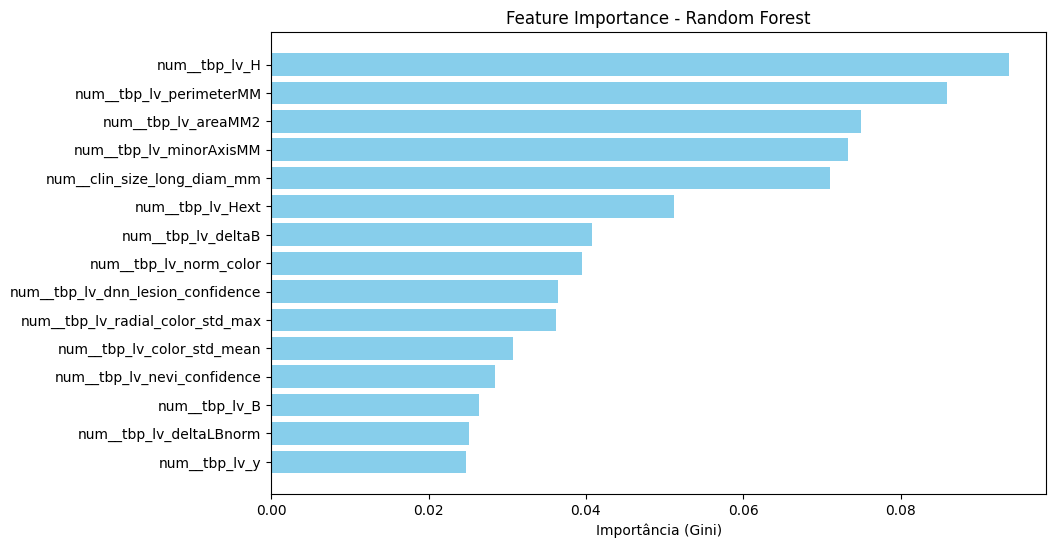

In [105]:
print(f"Melhor F1 Macro: {grid_search.best_score_:.4f}")
print(f"Melhores Parâmetros: {grid_search.best_params_}")

rf_model = best_model.named_steps['rf']

feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

df_importancia = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
})

df_importancia = df_importancia.sort_values(by='importance', ascending=False)

print("\n--- Top 10 Features Mais Importantes ---")
print(df_importancia.head(10))

plt.figure(figsize=(10, 6))
plt.barh(df_importancia['feature'][:15], df_importancia['importance'][:15], color='skyblue')
plt.gca().invert_yaxis() 
plt.xlabel('Importância (Gini)')
plt.title('Feature Importance - Random Forest')
plt.savefig("./RF_top10_features")
plt.show()